In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import torch
import torch.nn as nn
import pandas as pd
import segmentation_models_pytorch as smp
import os
import rasterio
from torchgeo.transforms import indices
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import wandb
from sklearn.preprocessing import minmax_scale

%cd ../
import src.data_geo.dataloading as dl
import src.data_geo.transforms as tf
import src.data_geo.preprocessing as pp    

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)  # our rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

/home/broug/Desktop/DD-Finland-Forests


In [9]:
if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'device: {device}')

device: cuda


In [10]:
PATH = '~/Desktop/DD-Finland-Forests'
dir_tiles = 'data/train/train_features/'
dir_target = 'data/train/train_agbm/'
dir_test = 'data/test/test_features/'
metadata = 'data/features_metadata.csv'

In [11]:
transforms = nn.Sequential(
    indices.AppendNDVI(index_nir=6, index_red=2), # NDVI, index 15
    tf.AppendRatioAB(index_a=11, index_b=12),  # VV/VH Ascending, index 16
)

In [12]:
max_chips=None  # set how many data tiles to load; if tile_file=None then this limits tiles, not chips (multiple tiles per chipid)
dataset = dl.SentinelDataset(
                        metadata=metadata,
                        path=PATH,
                        tile_file=None,
                        dir_tiles=dir_tiles,
                        dir_target=dir_target,
                        max_chips=max_chips,
                        transform=transforms,
                        device=device
                             )

In [13]:
channel_map = {
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-VV/VH-Asc: Cband-10m'
}
month_map = {
    0: 'Sep', 1: 'Oct', 2: 'Nov', 3: 'Dec',
    4: 'Jan', 5: 'Feb', 6: 'Mar', 7: 'Apr',
    8: 'May', 9: 'Jun', 10: 'Jul', 11: 'Aug'
}
plot_channels = {
    0: {'s2_rgb_idxs': [2, 1, 0], 'title': 'RGB'}, # RGB image, special case 
    1: {'data': 'target', 'title': 'AGBM', 'LogNorm': True}, # AGBM target data, special case 
    2: {'channel_idx': 6},  # general case of visualizing by channel_index 
    3: {'channel_idx': 15},
    4: {'channel_idx': 10},
    5: {'channel_idx': 12}, 
    6: {'channel_idx': 16},
    7: {'s1_rgb_idxs': [11, 12, 16], 'title': 'SAR-RGB: VV,VH,VV/VH'}, # SAR psuedo-RGB, special case 
}

In [14]:
def plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map):
    sample = dataset[tile_idx]
    chipid, month_id = dataset.df_tile_list.iloc[tile_idx].values
    tile_name = f'Chip {chipid} {month_map[month_id]}'
    
    pp.plot_bands(tile=sample['image'].detach().cpu(),
               target=sample['label'].detach().cpu(),
               tile_name=tile_name,
               plot_channels=plot_channels,
               channel_map=channel_map
              )

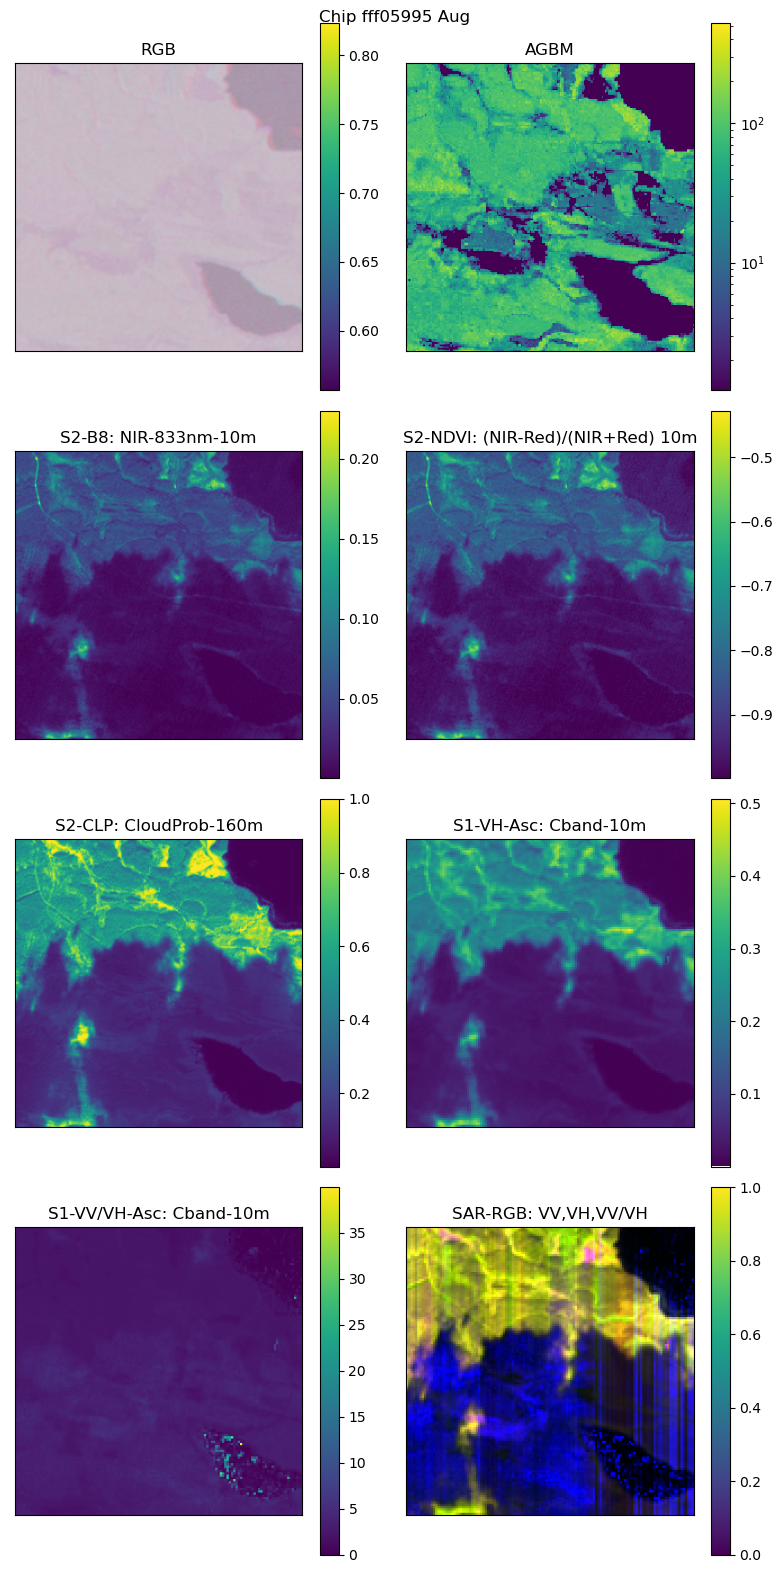

In [15]:
tile_idx = 104267 
plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map)

In [16]:
def diff_ndvi_sar_vh(tile, ndvi_idx, vh_idx):
    ndvi = minmax_scale(tile[ndvi_idx].clamp(0))
    vh = minmax_scale(tile[vh_idx])
    return ndvi - vh

def calc_frac_over_thresh(img, thresh=0.5):
    total_vals = 256*256.
    count_bad = img[np.abs(img)>thresh].shape[0]
    count_bad += np.isnan(img).sum()
    return round((count_bad)/total_vals, 3)

def calc_quality_scores(dataset):
    scores = []
    for ix, sample in tqdm(enumerate(dataset), total=len(dataset)):
        chipid, month_idx = dataset.df_tile_list.iloc[ix].values
        tile = sample['image'].detach().clone().cpu()
        diff_img = diff_ndvi_sar_vh(tile, ndvi_idx=15, vh_idx=12)
        score = 1 - calc_frac_over_thresh(diff_img, thresh=0.5)
        scores.append((chipid, month_idx, score))
    return pd.DataFrame(scores, columns=['chipid', 'month', 'score'])

def find_best_month_score(scores: np.ndarray, high_thresh: float = 0.95, min_thresh: float = 0.9) -> int:
    '''Calculate and return the best band score per heuristics
    
    Inputs:
    scores -- quality metric for each of 12 months from Sep = 0 to Aug = 11 
    high_thresh -- high quality score threshold 
    min_thresh -- lower quality score threshold 
    '''
    
    ranked_indexes = [8, 9, 7, 10, 11, 0] # best months for vegetation data 
    
    for idx in ranked_indexes: # first see if any favored months meet high threshold
        if scores[idx] > high_thresh:
            return idx, scores[idx]

    for idx in ranked_indexes: # then try lower threshold 
        if scores[idx] > min_thresh:
            return idx, scores[idx]
    
    idx = np.argmax(scores)
    return idx, scores[idx] # otherwise return month with highest score 

def find_best_months(df_scores):
    best_months = []
    for chipid in tqdm(df_scores['chipid'].unique()):
        idx, score = find_best_month_score(df_scores[df_scores['chipid']==chipid]['score'].values)
        best_months.append((chipid, idx, score))
    return pd.DataFrame(best_months, columns=['chipid', 'month', 'score'])

In [18]:
df_scores = calc_quality_scores(dataset)

100%|██████████| 104268/104268 [47:47<00:00, 36.37it/s]


In [19]:
df_best = find_best_months(df_scores)
df_best.to_csv('./TILE_LIST_BEST_MONTHS.csv')

100%|██████████| 8689/8689 [00:58<00:00, 148.76it/s]


In [24]:
dir_test = 'data/test'
dataset_test = dl.SentinelDataset(
                            tile_file=None,
                             dir_tiles=dir_test,  # change to dir_test
                             dir_target=None,     # no target tiles for test data 
                            metadata=metadata,
                            path=PATH,
                             max_chips=max_chips,
                             transform=transforms,
                             device=device,
                             is_train=False
                             )

In [25]:
df_scores_test = calc_quality_scores(dataset_test)
df_best_test = find_best_months(df_scores_test)
df_best_test.to_csv('./TILE_LIST_BEST_TEST_MONTHS_v2.csv')

100%|██████████| 2773/2773 [00:06<00:00, 416.52it/s]
